# Combustion Chemistry in Isobaric Reactor: Postprocessing DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
from   numpy                         import diff
import                           cantera as ct

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

import importlib
import importlib.util


# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
DataDir                 = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_500Cases_CH4_/')

path_to_run_fld         = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_500Cases_CH4_Autoencoded/DeepONet/Run_2/')

path_to_autoencoder_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/0DReact_Isobaric_500Cases_CH4_Autoencoder/Autoencoder/LIN_10/')



FigDir           = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


DataType         = 'train'
CasesVec         = range(0,500,100)
# DataType         = 'test'
# CasesVec         = range(10) #[1,0,2]



NSamples         = 1

FixedMinVal      = 1.e-14 

PCA_NAME         = 'All'

scale            = 'lin'
MinVal           = 1.e-40

 
ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

## Loading Encoder

### Loading ROMNet's Input Data File

In [3]:
spec                       = importlib.util.spec_from_file_location("inputdata", path_to_autoencoder_fld+'./ROMNet_Input.py')
foo_1                      = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo_1)
InputData_Encod            = foo_1.inputdata(WORKSPACE_PATH)


InputData_Encod.InputFilePath    = path_to_autoencoder_fld+'/ROMNet_Input.py'
InputData_Encod.train_int_flg    = 0
InputData_Encod.path_to_run_fld  = path_to_autoencoder_fld

### Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData_Encod.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.architecture, surrogate_type)

model_Encod = rmnt.model.Model_TF(InputData_Encod)

if (InputData_Encod.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData_Encod.phys_system)
    system = System(InputData_Encod)
    
model_Encod.build(InputData_Encod, None, Net, system)#, loadfile_no='000027')


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - autoencoder.py            ]:   Constructing Autoencoder: 
[ROMNet - system_of_components.py   ]:     Constructing System of Components: Encoder
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x16d7038e0>, <keras.layers.core.dense.Dense object at 0x16db480a0>])
[ROMNet - system_of_components.py   ]:     Constructing System of Components: Decoder
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x16db48a30>, <keras.layers.core.dropout.Dropout object at 0x16db8b610>, <keras.layers.core.dense.D

In [5]:
input_vars      = pd.read_csv(InputData_Encod.path_to_data_fld+'/../Orig/CleanVars_ToRed.csv', header=None).to_numpy()[0,:]
input_vars_not  = pd.read_csv(InputData_Encod.path_to_data_fld+'/../Orig/CleanVars_NotToRed.csv', header=None).to_numpy()[0,:]

input_vars0     = []
for var in input_vars:
    input_vars0.append(var+'0')
input_vars_not0 = []
for var in input_vars_not:
    input_vars_not0.append(var+'0')


output_vars_not0= input_vars_not0
output_vars     = ['x_'+str(ix+1) for ix in range(InputData_Encod.NRODs)]
output_vars0    = ['x0_'+str(ix+1) for ix in range(InputData_Encod.NRODs)]

In [6]:
# input_data_Not       = Data[np.append(['t'],input_vars_not0)]
# input_data           = pd.DataFrame(model_Encod.net.system_of_components['Encoder'].components['FNN'].call(Data[input_vars0], model.net.layers_dict, None, training=False), columns=output_vars0)
# input_data           = pd.concat([input_data_Not,input_data], axis=1)

# output_data_Not      = Data[np.append(['t'],input_vars_not)]
# output_data          = pd.DataFrame(model_Encod.net.system_of_components['Encoder'].components['FNN'].call(Data[input_vars], model.net.layers_dict, None, training=False), columns=output_vars)
# output_data          = pd.concat([output_data_Not,output_data], axis=1)

## Loading Surrogate

### Loading ROMNet's Input Data File

In [7]:
spec      = importlib.util.spec_from_file_location("inputdata", path_to_run_fld+'./ROMNet_Input.py')
foo_2     = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo_2)
InputData = foo_2.inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld

## Loading Tensorflow's Model for the Network 

In [8]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.architecture, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x16ddb5490>, <keras.layers.core.dense.Dense object at 0x16de7ad30>, <keras.layers.core.dense.Dense object at 0x16de6bd30>, <keras.layers.core.dense.Dense object at 0x16de6bf10>, <keras.layers.core.dense.Dense object at 0x16de6b5b0>, <keras.layers.core.dense.Dense object at 0x16d700dc0>])
[ROMNet - component.py

[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x16e3d4cd0>, <keras.layers.core.dense.Dense object at 0x16e44f760>, <keras.layers.core.dense.Dense object at 0x16e454a30>, <keras.layers.core.dense.Dense object at 0x16e454fa0>, <keras.layers.core.dense.Dense object at 0x16e45f490>, <keras.layers.core.dense.Dense object at 0x16e45f940>])
[ROMNet - component.py              ]:       Constructing Component: Stretch
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x16e45ffa0>, <keras.layers.core.dense.Dense object at 0x16e3df2e0>, <keras.layers.core.dense.Dense object at 0x16e4d5280>, <keras.layers.core.dense.Dense object at 0x16e4d5760>, <keras.layers.core.dense.Dense object at 0x16e4d5c10>, <keras.layers.core.dense.Dense obje

[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_8-Main-HL_3
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_8-Main-HL_3
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_8-Main-HL_4
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_8-Main-HL_4
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_8-Main-HL_5
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_8-Main-HL_5
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_9_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_9_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_9_Normalization
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Branch_9_Normalization
[ROMNet - hdf5

[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Trunk_9-Main-HL_5
[ROMNet - hdf5_format.py            ]:     Loaded Weights for Layer  DeepONet-Trunk_9-Main-HL_5
'load_params' took 0.576250 s


[ROMNet - model_tf.py    ]:   Saving ML Model Parameters to File:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/0DReactor/DeepONet/../../../../../../ROMNet/0DReact_Isobaric_500Cases_CH4_Autoencoded/DeepONet/Run_2//Model/Params/Initial.h5
'save_params' took 0.829655 s

'build' took 17.654506 s



## Evaluating DeepONet on Test Data

### Loading Simulations Info

In [9]:
FileName     = DataDir + '/Orig/train/ext/y.csv.1'
Data         = pd.read_csv(FileName, header=0)
VarNames     = list(Data.columns)
VarNames.remove('t')

FileName     = DataDir + '/Orig/train/ext/CleanVars.csv'
Data         = pd.read_csv(FileName, header=0)
VarNamesAnti = list(Data.columns)


FileName     = DataDir + '/Orig/'+DataType+'/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = DataDir + '/Orig/'+DataType+'/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics        = len(ICVecs)

### Loading Variables Info

In [10]:
Vars  = VarNamesAnti

Vars0 = []
for Var in Vars:
    Vars0.append(str(Var)+'0')
    
InputVars = Vars0+['t']

T =  1413.0 K
T =  1005.0 K
T =  1179.0 K
T =  1725.0 K
T =  1503.0 K


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


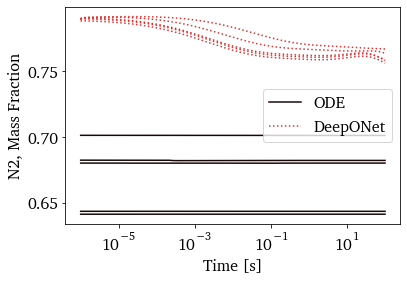

In [63]:
VarOI      = 'N2'
VarOI_Name = 'N2'




ax   = []
fig  = []
fig1 = plt.figure()
fig.append(fig1)
ax.append(plt.axes())

MSE   = 0.

jTest = 0
for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
    #####################################################################################################
    FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)[['t']+Vars]
    tVec0        = Data.to_numpy()[0,0]
    tVec         = Data.to_numpy()[:,0] - tVec0
    tVec[tVec == 0.] = FixedMinVal
    y_Data       = Data[Vars]
    Data0        = Data[Data['t'] == 0.][Vars]
    print('T = ', Data['T'].to_numpy()[0], 'K')
    
    Data0            = pd.DataFrame([y_Data.to_numpy()[0,:]], columns=Vars0)
    Data0            = Data0.loc[Data0.index.repeat(Nts)]
    Data0.columns    = Vars0
    Data0['t']       = tVec
    Data0.reset_index(drop=True, inplace=True)
        
    if (jTest == 0):
        Label1 = 'ODE'
        Label2 = 'PCA'
        Label3 = 'DeepONet'
        #Label3 = 'flexDeepONet'
    else:
        Label1 = ''
        Label2 = ''
        Label3 = ''

        
    input_data_Not       = y_Data[input_vars_not]
    input_data           = pd.DataFrame(model_Encod.net.system_of_components['Encoder'].components['FNN'].call(y_Data[input_vars], model_Encod.net.layers_dict, None, training=False), columns=output_vars)
    y_Data               = pd.concat([input_data_Not,input_data,Data0['t']], axis=1)
    
    ax[0].plot(tVec+tVec0, y_Data[VarOI],  '-', c=ColorVec[0], label=Label1)

    

    input_data_Not       = Data0[input_vars_not0]
    input_data           = pd.DataFrame(model_Encod.net.system_of_components['Encoder'].components['FNN'].call(Data0[input_vars0], model_Encod.net.layers_dict, None, training=False), columns=output_vars0)
    input_data           = pd.concat([input_data_Not,input_data,Data0['t']], axis=1)

    y_Enc                = pd.DataFrame(model.predict(input_data), columns=list(input_vars_not)+output_vars)

    ax[0].plot(tVec+tVec0, y_Enc[VarOI], ':', c=ColorVec[1], label=Label3)

#     if (jTest == 0):   
#         MSE  = (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2
#     else:
#         MSE += (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2
     
    jTest += 1
    

ax[0].set_xscale('log')
ax[0].set_xlabel('Time [s]')
if (VarOI == 'T'):
    ax[0].set_ylabel('Temperature [K]')
else:
    ax[0].set_ylabel(r''+VarOI_Name+', Mass Fraction')
#ax[0].set_xlim([1.e-8,1.e-2])
ax[0].legend()
    
    
# MSE_ = MSE.sum(axis=0) / len(CasesVec) / (MSE.shape[0])
# print('Mean Squared Error = ', MSE_)
    

if (FigDir):
    fig[0].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+VarOI+'.eps', format='eps', bbox_inches='tight')

In [68]:
input_data

,T0,N20,NO0,NO20,OH0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,t
0,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,1.000000e-14
1,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,1.859514e-08
2,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,3.753606e-08
3,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,5.682919e-08
4,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,7.648108e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,9.255359e+01
996,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,9.427464e+01
997,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,9.602769e+01
998,1503.0,0.641298,0.0,0.0,0.0,-0.113816,0.081267,-0.201752,-0.151796,-0.023095,-0.155668,-0.161314,-0.032911,-0.109318,0.293509,9.781334e+01


### Loading and Plotting Test/Training Data

T =  1413.0 K
T =  1005.0 K
T =  1179.0 K
T =  1725.0 K
T =  1503.0 K


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


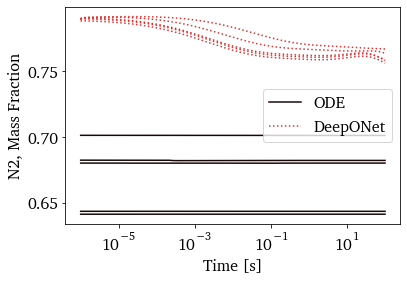

In [11]:
VarOI      = 'N2'
VarOI_Name = 'N2'


iVar     = Vars.index(VarOI)


ax   = []
fig  = []
fig1 = plt.figure()
fig.append(fig1)
ax.append(plt.axes())

MSE   = 0.

jTest = 0
for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
    #####################################################################################################
    FileName     = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)[['t']+Vars]
    tVec0        = Data.to_numpy()[0,0]
    tVec         = Data.to_numpy()[:,0] - tVec0
    tVec[tVec == 0.] = FixedMinVal
    y_Data       = Data[Vars]
    Data0        = Data[Data['t'] == 0.][Vars]
    print('T = ', Data['T'].to_numpy()[0], 'K')
    
    Data0            = pd.DataFrame([y_Data.to_numpy()[0,:]], columns=Vars0)
    Data0            = Data0.loc[Data0.index.repeat(Nts)]
    Data0.columns    = Vars0
    Data0['t']       = tVec
    Data0.reset_index(drop=True, inplace=True)
        
    if (jTest == 0):
        Label1 = 'ODE'
        Label2 = 'PCA'
        Label3 = 'DeepONet'
        #Label3 = 'flexDeepONet'
    else:
        Label1 = ''
        Label2 = ''
        Label3 = ''

    ax[0].plot(tVec+tVec0, y_Data[VarOI],  '-', c=ColorVec[0], label=Label1)

    

    input_data_Not       = Data0[input_vars_not0]
    input_data           = pd.DataFrame(model_Encod.net.system_of_components['Encoder'].components['FNN'].call(Data0[input_vars0], model_Encod.net.layers_dict, None, training=False), columns=output_vars0)
    input_data           = pd.concat([input_data_Not,input_data,Data0['t']], axis=1)

    y_Enc                = pd.DataFrame(model.predict(input_data), columns=list(input_vars_not)+output_vars)

    output_data_Not      = y_Enc[input_vars_not]
    output_data          = pd.DataFrame(model_Encod.net.system_of_components['Decoder'].components['FNN'].call(y_Enc[output_vars].to_numpy(), model_Encod.net.layers_dict, None, training=False), columns=input_vars)
    y_Pred               = pd.concat([output_data_Not,output_data], axis=1)

    ax[0].plot(tVec+tVec0, y_Pred[VarOI], ':', c=ColorVec[1], label=Label3)

#     if (jTest == 0):   
#         MSE  = (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2
#     else:
#         MSE += (y_Pred[1::] - y_Data[1::])**2#/y_Data[1::]**2
     
    jTest += 1
    

ax[0].set_xscale('log')
ax[0].set_xlabel('Time [s]')
if (VarOI == 'T'):
    ax[0].set_ylabel('Temperature [K]')
else:
    ax[0].set_ylabel(r''+VarOI_Name+', Mass Fraction')
#ax[0].set_xlim([1.e-8,1.e-2])
ax[0].legend()
    
    
# MSE_ = MSE.sum(axis=0) / len(CasesVec) / (MSE.shape[0])
# print('Mean Squared Error = ', MSE_)
    

if (FigDir):
    fig[0].savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_'+VarOI+'.eps', format='eps', bbox_inches='tight')

In [44]:
# input_data_Not       = Data[input_vars_not]
# input_data           = pd.DataFrame(model_Encod.net.system_of_components['Encoder'].components['FNN'].call(Data[input_vars], model_Encod.net.layers_dict, None, training=False), columns=output_vars)
# input_data           = pd.concat([input_data_Not,input_data], axis=1)

# output_data_Not      = input_data[input_vars_not]
# output_data          = pd.DataFrame(model_Encod.net.system_of_components['Decoder'].components['FNN'].call(input_data[output_vars].to_numpy(), model_Encod.net.layers_dict, None, training=False), columns=input_vars)
# y_Pred               = pd.concat([output_data_Not,output_data], axis=1)


# input_data_Not       = Data0[input_vars_not0]
# input_data           = pd.DataFrame(model_Encod.net.system_of_components['Encoder'].components['FNN'].call(Data0[input_vars0], model_Encod.net.layers_dict, None, training=False), columns=output_vars0)
# input_data           = pd.concat([input_data_Not,input_data], axis=1)

# output_data_Not      = input_data[input_vars_not0]
# output_data          = pd.DataFrame(model_Encod.net.system_of_components['Decoder'].components['FNN'].call(input_data[output_vars0].to_numpy(), model_Encod.net.layers_dict, None, training=False), columns=input_vars0)
# y_Pred               = pd.concat([output_data_Not,output_data], axis=1)

In [55]:
# QoI = 'N0'

# # plt.scatter(Data[QoI], y_Pred[QoI])
# # plt.plot([0.,Data[QoI].max()], [0.,Data[QoI].max()])

# plt.scatter(Data0[QoI], y_Pred[QoI])
# plt.plot([0.,Data0[QoI].max()], [0.,Data0[QoI].max()])

## Plotting Loss Histories

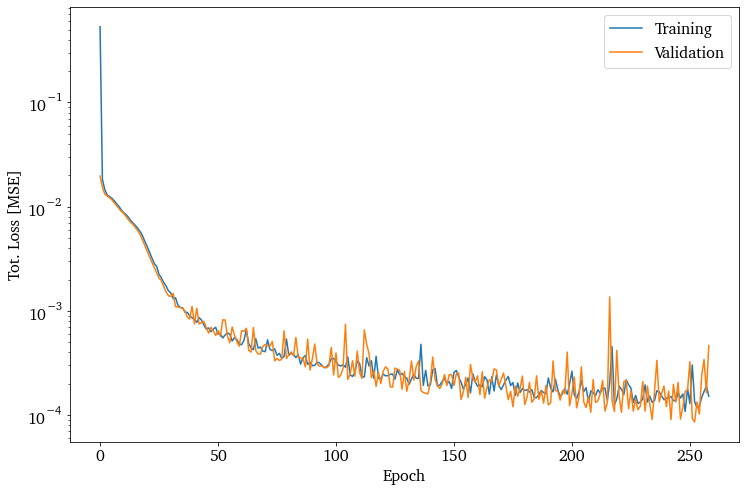

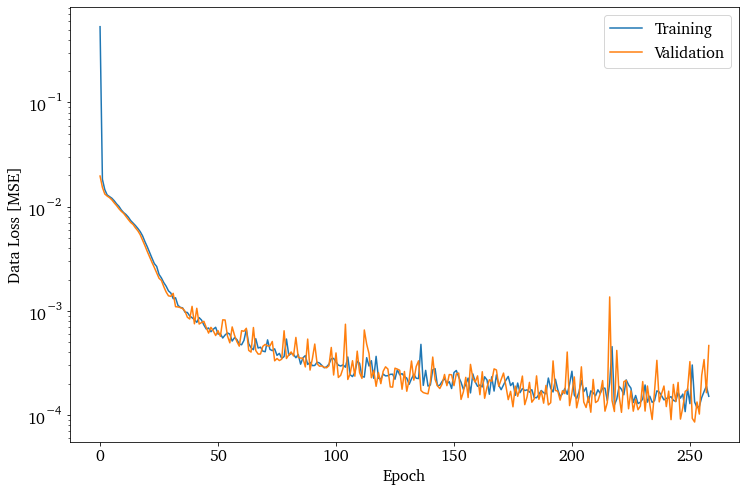

In [14]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')


# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Trunk's Outputs

TypeError: call_classic() got multiple values for argument 'training'

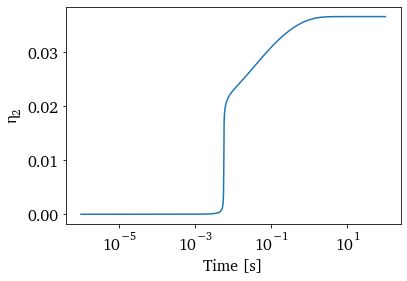

In [15]:
iTrunk           = 1
iTest            = 0


FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

fig = plt.figure()
plt.plot(Data['t'], Data[Vars[iTrunk]])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\eta_{'+str(iTrunk+1)+'}$')



iVarVec = range(0,6,1)

tVecTot = np.logspace(-14,4,1000)

output_ = model.net.system_of_components['DeepONet'].components['Trunk_'+str(iTrunk+1)].call(tVecTot[...,np.newaxis], model.net.layers_dict, None, None, training=False)

fig = plt.figure()

for iVar in iVarVec:

    plt.plot(tVecTot, output_[:,iVar])

#plt.xlim([1.e-6, 1.e-2])
plt.xscale('log')
plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+str(iTrunk+1)+'_{i}}$')

## Evaluating Branches' Outputs

In [ ]:
# FileName     = DataDir + '/Orig/train/ext/SimIdxs.csv'
# Data         = pd.read_csv(FileName, header=0)
# SimIdxs      = Data.to_numpy(int)


# FileName     = DataDir + '/Orig/train/ext/ICs.csv'
# Data         = pd.read_csv(FileName)
# ICVecs       = Data.to_numpy()
# n_ics        = len(ICVecs)
n_ics         = 500

Cols   = []
NewFlg = True
for iC in range(n_ics):

    try:
        
        FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iC+1)
        Data             = pd.read_csv(FileName, header=0)[['t']+Vars]

        DataICTemp       = Data[Vars].iloc[0]

        if (NewFlg):
            DataIC           = DataICTemp
            NewFlg           = False
        else:
            DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))
            
    except:
        pass

tVec              = Data['t']
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

DataIC.head()

In [ ]:
iBranch = 0
iVar    = 5



output_ = model.net.system_of_components['DeepONet'].components['Branch_'+str(iBranch+1)].call(DataIC.to_numpy(), model.net.layers_dict, None, None, training=False)



#%matplotlib qt

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(DataIC['T'], DataIC['H2'], output_[:,iVar], c='r')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$H_2$')
#ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_{'+str(iVar+1)+'}}$')
ax.set_zlabel(r'$\alpha_{'+str(iBranch+1)+'_D}$')

## Evaluating Rigid Block + Trunk's Outputs

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), model.net.layers_dict, None, None, training=False)
output_ = np.log(1. + np.exp(output_))

for iBranch in range(len(Vars)):
    #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
    ax.scatter(DataIC['T'], DataIC['H2'], output_[:,iBranch], label=r'$j='+str(iBranch+1)+'$')
    
    DF = pd.DataFrame(np.concatenate([DataIC['T'].to_numpy()[...,np.newaxis], DataIC['H2'].to_numpy()[...,np.newaxis], output_[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
    DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iVar]+'.csv', index=False)

ax.set_xlabel('\n'+r'$T$', rotation = 0)
ax.set_ylabel(r'           $H_2$', rotation = 0)
ax.set_zlabel(r'         $\bar{t}_j$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.legend()
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput.eps', format='eps', bbox_inches='tight')

In [ ]:
for iBranch in range(len(Vars)):

    DF = pd.DataFrame(np.concatenate([DataIC['T'].to_numpy()[...,np.newaxis], DataIC['H2'].to_numpy()[...,np.newaxis], output_[:,iBranch][...,np.newaxis]], axis=1), columns=['T_0','H2_0',Vars[iBranch]])
    DF.to_csv('/Users/sventur/Desktop/Shifts/'+Vars[iBranch]+'.csv', index=False)

In [ ]:
VarNames=['T',
 'H_{2}',
 'H',
 'O',
 'O_{2}',
 'OH',
 'H_{2}O',
 'HO_{2}',
 'H_{2}O_{2}',
 'N',
 'NH',
 'NH_{2}',
 'NH_{3}',
 'NNH',
 'NO',
 'NO_{2}',
 'N_{2}O',
 'HNO',
 'N_{2}']


fig = plt.figure()

for iBranch in [0,1,2,3,5,9,12]:
    plt.scatter(DataIC['T'], output_[:,iBranch], label=r'$j='+VarNames[iBranch]+'$', s=30)
    
plt.xlabel(r'$T_0$')
plt.ylabel(r'$\bar{t}_j$')
#plt.yscale('log')
plt.xlim([1000,2000])
plt.ylim([0,80])

plt.legend(fontsize=30)
#ax.set_zscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+DataType+'_DeepONet_RigidOutput_2D.eps', format='eps', bbox_inches='tight')
    
## np.exp(np.log(1.e-6) - np.log(40))

In [ ]:
# fig = plt.figure(figsize=(10,10))
# ax  = fig.add_subplot(projection='3d')


# output_ = model.net.system_of_components['DeepONet'].components['Rigid'].call(DataIC.to_numpy(), training=False)

# output_.shape

# for iBranch in range(7,14):
#     #ax.scatter(DataIC['PC_1'], DataIC['PC_2'], np.exp(output_[:,iBranch]))
#     ax.scatter(DataIC['PC_1'], DataIC['PC_2'], output_[:,iBranch], label=r'$\eta_{'+str(iBranch+1)+'}$')


# ax.set_xlabel(r'$\eta_{'+str(1)+'_0}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'_0}$')
# ax.set_zlabel(r'$\log(\bar{t})$')
# ax.legend()
# #ax.set_zscale('log')

In [ ]:
iVarVec   = [0,1,2,3,5,9,12]

for iVar in iVarVec:

    NewFlg   = True
    fig, ax1 = plt.subplots()
    ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    for iTest in CasesVec:
        
        FileName         = DataDir + '/Orig/'+DataType+'/ext/y.csv.'+str(iTest+1)
        Data             = pd.read_csv(FileName, header=0)[['t']+Vars]
        
        tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
        yPCA_Data        = Data[Vars].to_numpy()
        Data0            = Data[Data['t'] == 0.][Vars]
#         yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
#         yPre_Data        = yPCA_Data.dot(A)
#         yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
#         Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)

        if NewFlg:
            Label1 = 'ODE'
            Label2 = 'Rigid Block Prepr.'
            NewFlg = False
        else:
            Label1 = None
            Label2 = None

    
        ax1.plot(tVec, yPCA_Data[:,iVar], color=ColorVec[0], label=Label1)

        ax2.plot(tVec*output_[iTest,iVar], yPCA_Data[:,iVar], color=ColorVec[1], label=Label2)

    #plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])
    
    color = ColorVec[0]
    ax1.set_xlabel(r'Time [s]', size=34)
    if (Vars[iVar] == 'T'):
        ax1.set_ylabel(r'Temperature [K]', color=color, size=34)
    else:
        ax1.set_ylabel(r'$'+VarNames[iVar]+'$, Mass Fraction', color=color, size=34)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')

    color = ColorVec[1]
    ax2.set_xlabel(r'      $t/\bar{t}_{'+VarNames[iVar]+'}$ [s]', color=color, size=34, labelpad=10)  # we already handled the x-label with ax1
    #ax2.set_ylabel(r'$x$', color=color, size=34)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.set_xscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #plt.legend(loc=4)
    
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_test_DeepONet_'+Vars[iVar]+'_Shift.eps', format='eps', bbox_inches='tight')

In [ ]:
### Experimenting

# n_clusters = 5

# from sklearn.cluster import KMeans
# X = output_.T
# kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
# kmeans.labels_

# for i_cluster in range(n_clusters):
#     print('Cluster '+str(i_cluster+1)+': ', np.array(Vars)[kmeans.labels_==i_cluster])